#### Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [23]:
import pandas as pd

In [2]:
import time
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns

from fastai.imports import *
# from fastai.structured import *
from fbprophet import Prophet

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

import statsmodels.api as sm
# Initialize plotly
init_notebook_mode(connected=True)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000);

In [4]:
pd.plotting.register_matplotlib_converters()

#### Load Train and Test Data

In [3]:
df_raw = pd.read_csv('train.csv', low_memory=False, parse_dates=['date'], index_col=['date'])
df_test = pd.read_csv('test.csv', low_memory=False, parse_dates=['date'], index_col=['date'])


In [11]:
df_raw.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [12]:
print("Train and Test shape are {} and {} respectively".format(df_raw.shape, df_test.shape))

Train and Test shape are (913000, 3) and (45000, 3) respectively


In [13]:
df_test.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


#### Seasonality Check

Resampling at week level

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


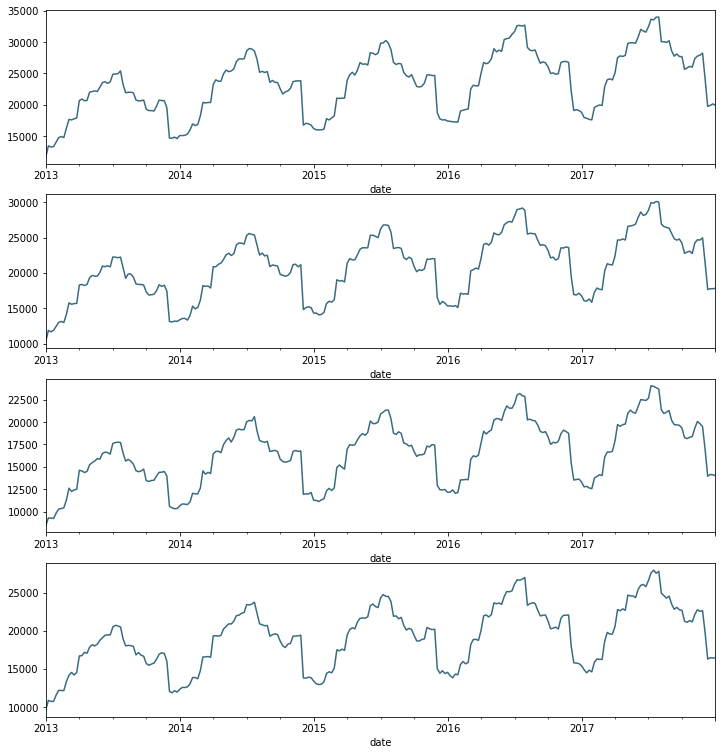

In [5]:
#### Seasonality Check
# preparation: input should be float type
df_raw['sales'] = df_raw['sales'] * 1.0

# store types
sales_a = df_raw[df_raw.store == 2]['sales'].sort_index(ascending = True)
sales_b = df_raw[df_raw.store == 3]['sales'].sort_index(ascending = True) # solve the reverse order
sales_c = df_raw[df_raw.store == 1]['sales'].sort_index(ascending = True)
sales_d = df_raw[df_raw.store == 4]['sales'].sort_index(ascending = True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
c = '#386B7F'

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

#All Stores have same trend... Weird Seems like the dataset is A Synthetic One..;

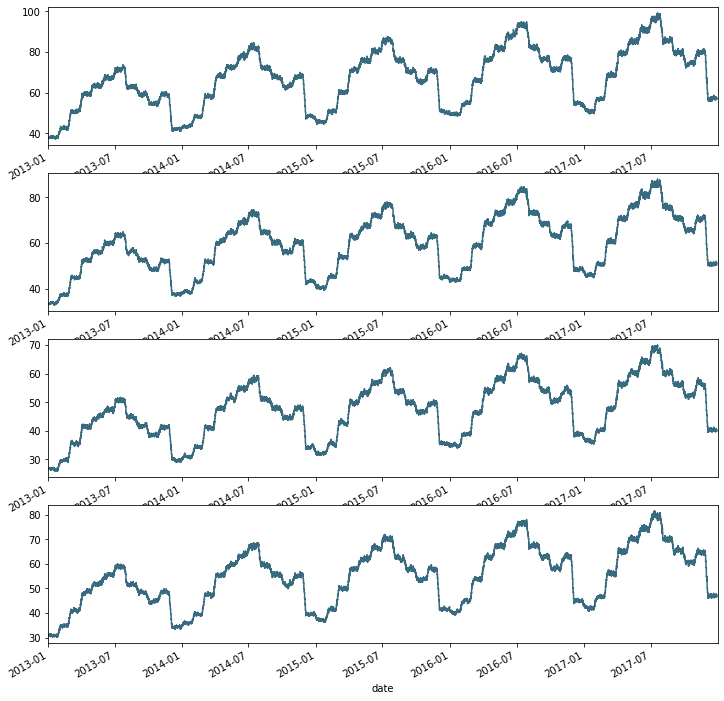

In [6]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Yearly
decomposition_a = sm.tsa.seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = sm.tsa.seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = sm.tsa.seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = sm.tsa.seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

In [7]:
date_sales = df_raw.drop(['store','item'], axis=1).copy() #it's a temporary DataFrame.. Original is Still intact..

In [8]:
date_sales.get_ftype_counts()

float64:dense    1
dtype: int64

In [9]:
y = date_sales['sales'].resample('MS').mean() 
y['2017':] #sneak peak

date
2017-01-01    39.826194
2017-02-01    44.383500
2017-03-01    53.075290
2017-04-01    62.590800
2017-05-01    65.850710
2017-06-01    70.974933
2017-07-01    75.573742
2017-08-01    66.219548
2017-09-01    62.350867
2017-10-01    57.494194
2017-11-01    61.922467
2017-12-01    44.849677
Freq: MS, Name: sales, dtype: float64

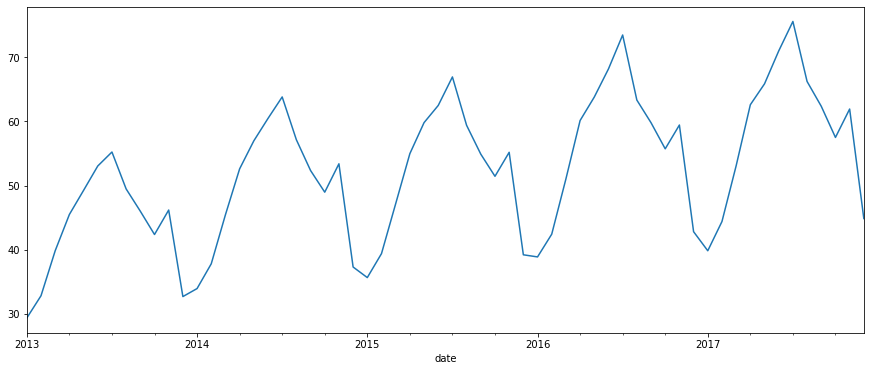

In [10]:
y.plot(figsize=(15, 6),);
#The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the middle(festive season maybe) of the year
# and again low at the end of the year...
#There is always an upward trend within any single year with a couple of low months in the mid of the year...

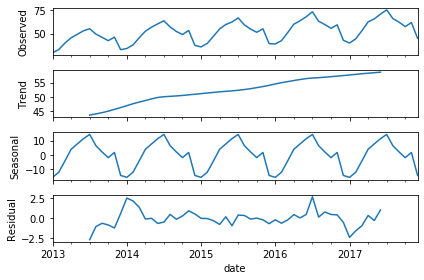

In [11]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot();
#The plot clearly shows that the sales is unstable, along with its obvious seasonality.;

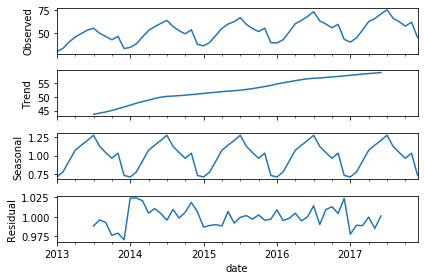

In [12]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition.plot();
#The plot above clearly shows that the sales is unstable, along with its obvious seasonality.;

In [13]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(date_sales, 24) # prediction for the last observed day (past 24 hours)

64.54166666666667

In [14]:
def plotMovingAverage(series, window, plot_intervals=False, scale=2, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, color='Black', label="Rolling mean trend", alpha=0.5)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, color='Black', label="Upper Bond / Lower Bond", alpha=.3)
        plt.plot(lower_bond, color='Black', alpha=.3)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:],color='Red', label="Actual values", alpha=.3)
    plt.legend(loc="upper left")
    plt.grid(True)

In [15]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [16]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual", alpha = 0.4)
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

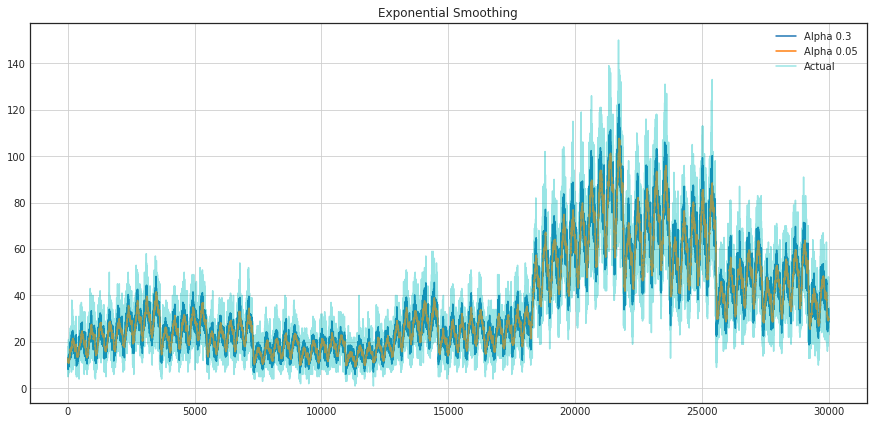

In [17]:
plotExponentialSmoothing(date_sales.sales[:30000], [0.3, 0.05])

In [18]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual", alpha = 0.1)
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

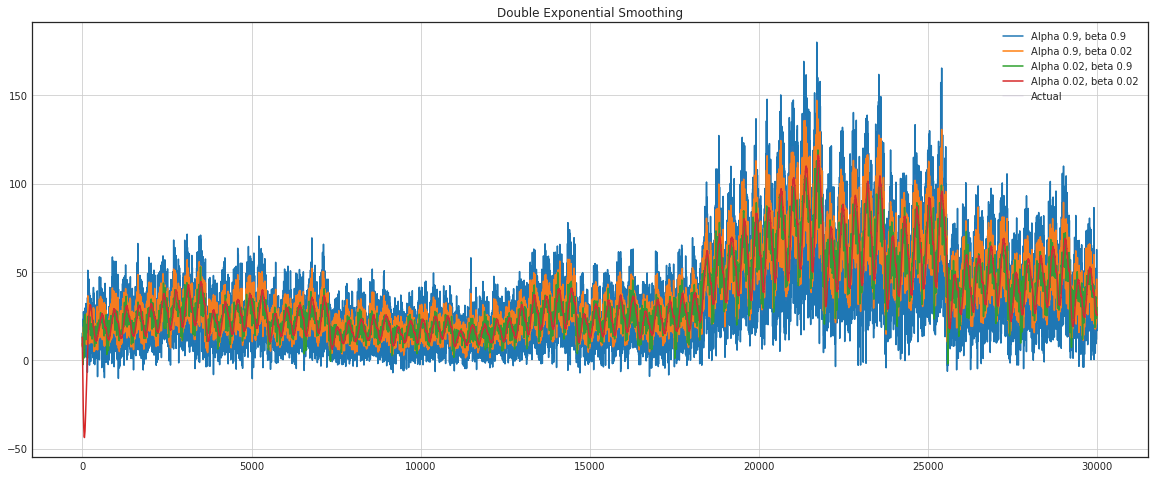

In [19]:
plotDoubleExponentialSmoothing(date_sales.sales[:30000], alphas=[0.9, 0.02], betas=[0.9, 0.02])

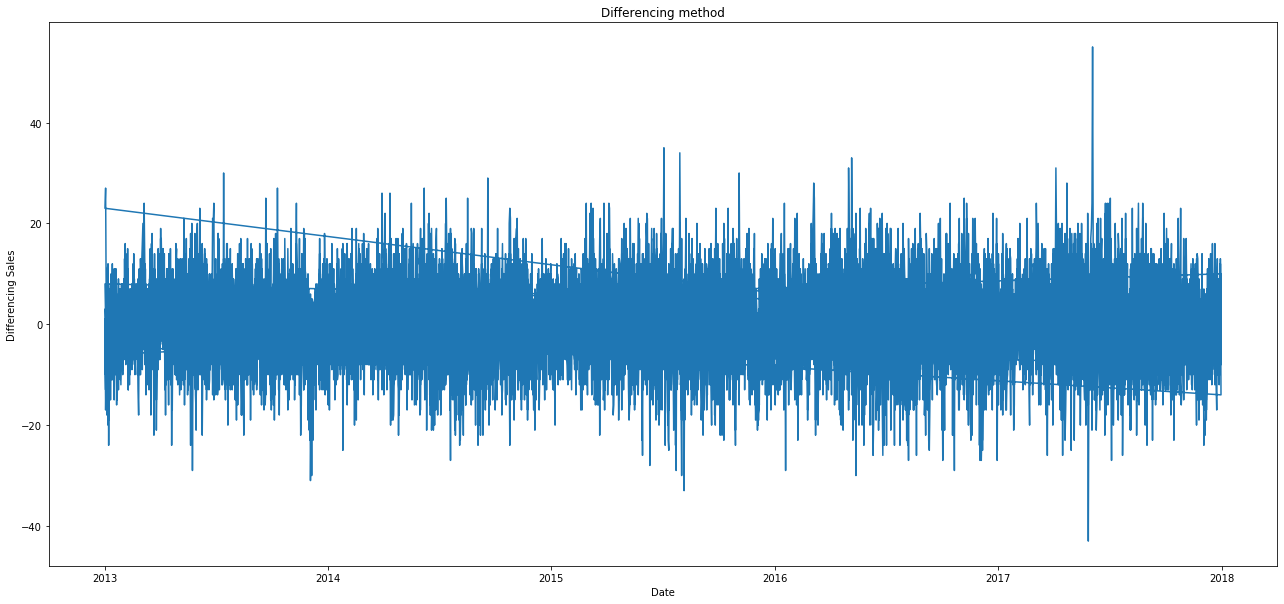

In [20]:
ts_diff = date_sales - date_sales.shift(7)
plt.figure(figsize=(22,10))
plt.plot(ts_diff[:20000])
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Sales");

In [21]:
df_raw = df_raw.reset_index()
df_test = df_test.reset_index()

In [22]:
import re
def add_datepart(df, fldname, drop=True):

    """
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','weekofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

add_datepart(df_raw,'date',False)
add_datepart(df_test,'date',False)

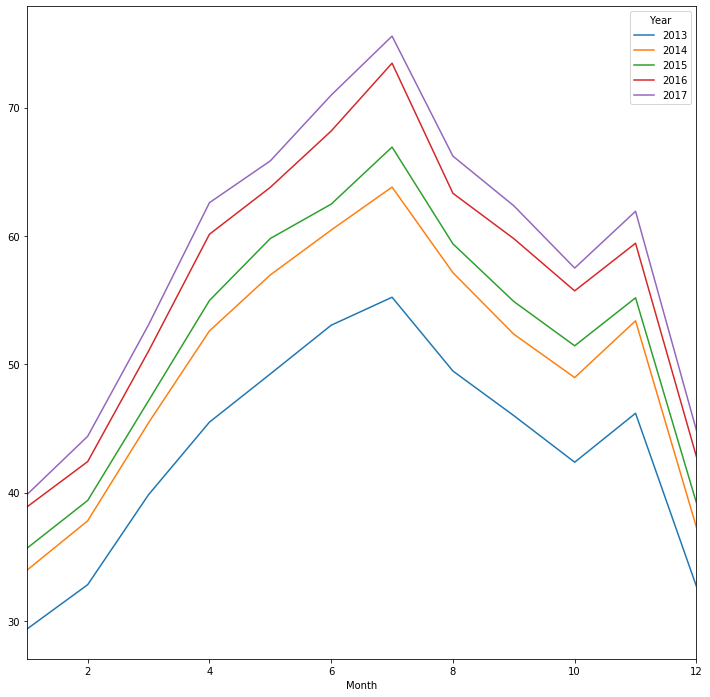

In [23]:
pivoted = pd.pivot_table(df_raw, values='sales', columns='Year', index='Month')
pivoted.plot(figsize=(12,12));

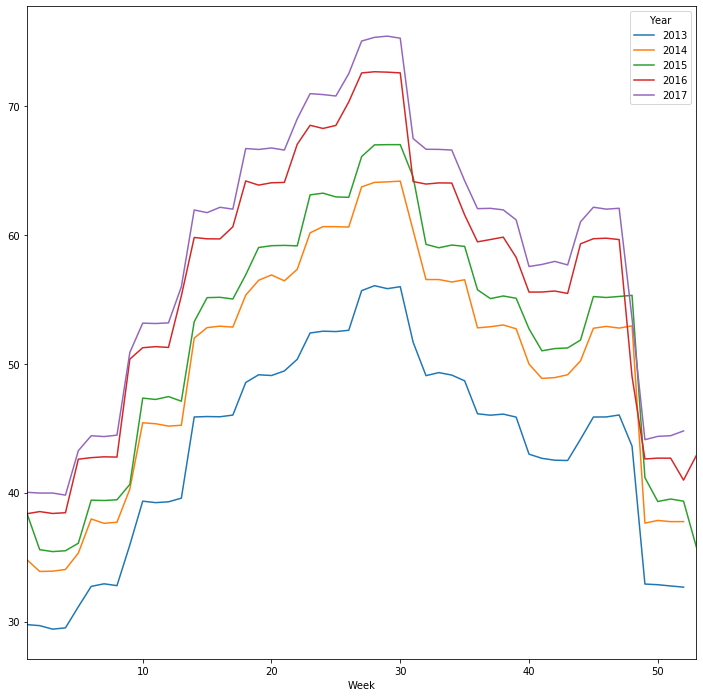

In [24]:
pivoted = pd.pivot_table(df_raw, values='sales' , columns='Year', index='Week')
pivoted.plot(figsize=(12,12));

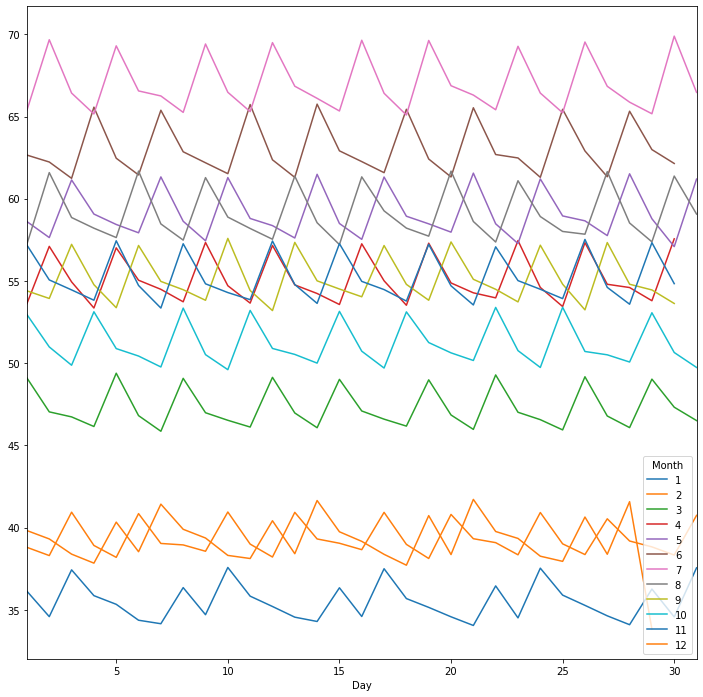

In [25]:
pivoted = pd.pivot_table(df_raw, values='sales' , columns='Month', index='Day')
pivoted.plot(figsize=(12,12));

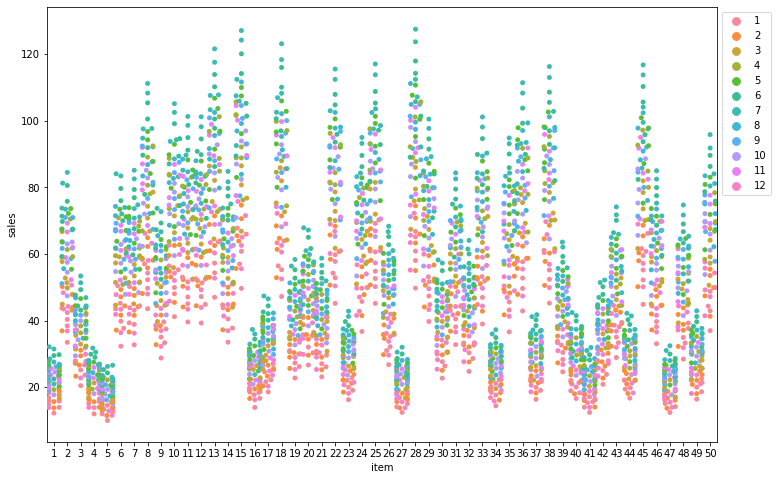

In [26]:
temp_1 = df_raw.groupby(['Year','Month','item'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8))
sns.swarmplot('item', 'sales', data=temp_1, hue = 'Month');
# Place legend to the right
plt.legend(bbox_to_anchor=(1, 1), loc=2);

<Figure size 864x576 with 0 Axes>

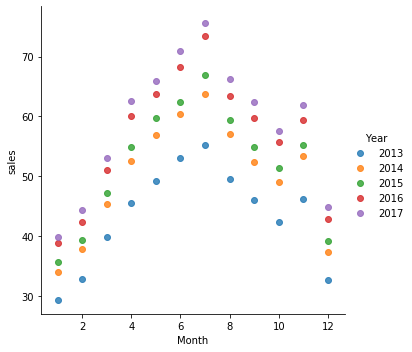

In [27]:
temp_1 = df_raw.groupby(['Year','Month'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8));
sns.lmplot('Month','sales',data = temp_1, hue='Year', fit_reg= False);

<Figure size 864x576 with 0 Axes>

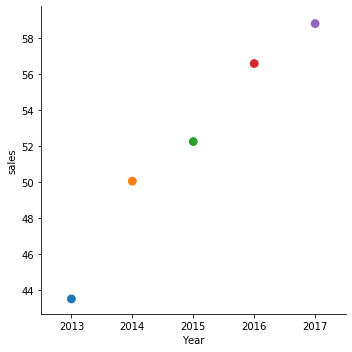

In [28]:
temp_1 = df_raw.groupby(['Year'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8));
sns.factorplot('Year','sales',data = temp_1, hue='Year', kind='point');

In [29]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [30]:
original_target = df_raw.sales.values
target, lambda_prophet = stats.boxcox(df_raw['sales'] + 1)
len_train=target.shape[0]
merged_df = pd.concat([df_raw, df_test])

In [32]:
merged_df.tail()

,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Month,Week,Year,date,id,item,sales,store,weekofyear
44995,27,1,86,False,False,False,False,False,False,3,13,2018,2018-03-27,44995.0,50,NaN,10,13
44996,28,2,87,False,False,False,False,False,False,3,13,2018,2018-03-28,44996.0,50,NaN,10,13
44997,29,3,88,False,False,False,False,False,False,3,13,2018,2018-03-29,44997.0,50,NaN,10,13
44998,30,4,89,False,False,False,False,False,False,3,13,2018,2018-03-30,44998.0,50,NaN,10,13
44999,31,5,90,True,False,True,False,False,False,3,13,2018,2018-03-31,44999.0,50,NaN,10,13


In [33]:
%%time
merged_df["median-store_item"] = merged_df.groupby(["item", "store"])["sales"].transform("median")
merged_df["mean-store_item"] = merged_df.groupby(["item", "store"])["sales"].transform("mean")
merged_df["mean-Month_item"] = merged_df.groupby(["Month", "item"])["sales"].transform("mean")
merged_df["median-Month_item"] = merged_df.groupby(["Month", "item"])["sales"].transform("median")
merged_df["median-Month_store"] = merged_df.groupby(["Month", "store"])["sales"].transform("median")
merged_df["median-item"] = merged_df.groupby(["item"])["sales"].transform("median")
merged_df["median-store"] = merged_df.groupby(["store"])["sales"].transform("median")
merged_df["mean-item"] = merged_df.groupby(["item"])["sales"].transform("mean")
merged_df["mean-store"] = merged_df.groupby(["store"])["sales"].transform("mean")

merged_df["median-store_item-Month"] = merged_df.groupby(['Month', "item", "store"])["sales"].transform("median")
merged_df["mean-store_item-week"] = merged_df.groupby(["item", "store",'weekofyear'])["sales"].transform("mean")
merged_df["item-Month-mean"] = merged_df.groupby(['Month', "item"])["sales"].transform("mean")# mean sales of that item  for all stores scaled
merged_df["store-Month-mean"] = merged_df.groupby(['Month', "store"])["sales"].transform("mean")# mean sales of that store  for all items scaled

# adding more lags (Check the rationale behind this in the links attached)
lags = [90,91,98,105,112,119,126,182,189,364]
for i in lags:
#     print("Done For Lag {}".format(i))
    merged_df['_'.join(['item-week_shifted-', str(i)])] = merged_df.groupby(['weekofyear',"item"])["sales"].transform(lambda x:x.shift(i).sum()) 
    merged_df['_'.join(['item-week_shifted-', str(i)])] = merged_df.groupby(['weekofyear',"item"])["sales"].transform(lambda x:x.shift(i).mean()) 
    merged_df['_'.join(['item-week_shifted-', str(i)])].fillna(merged_df['_'.join(['item-week_shifted-', str(i)])].mode()[0], inplace=True)
    ##### sales for that item i days in the past
    merged_df['_'.join(['store-week_shifted-', str(i)])] = merged_df.groupby(['weekofyear',"store"])["sales"].transform(lambda x:x.shift(i).sum())
    merged_df['_'.join(['store-week_shifted-', str(i)])] = merged_df.groupby(['weekofyear',"store"])["sales"].transform(lambda x:x.shift(i).mean()) 
    merged_df['_'.join(['store-week_shifted-', str(i)])].fillna(merged_df['_'.join(['store-week_shifted-', str(i)])].mode()[0], inplace=True)


CPU times: user 42.7 s, sys: 4.16 s, total: 46.8 s
Wall time: 47.5 s


In [34]:
df_raw.drop('sales', axis=1, inplace=True)
merged_df.drop(['id','date','sales'], axis=1, inplace=True)

In [35]:
merged_df.head(1)

,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Month,...,item-week_shifted-_119,store-week_shifted-_119,item-week_shifted-_126,store-week_shifted-_126,item-week_shifted-_182,store-week_shifted-_182,item-week_shifted-_189,store-week_shifted-_189,item-week_shifted-_364,store-week_shifted-_364
0,1,1,1,False,True,False,True,False,True,1,...,14.62543,32.529412,14.524648,32.529412,14.131579,32.529412,14.285068,32.529412,14.717391,32.425267


In [36]:
# comes from the public kernel
merged_df = merged_df * 1
params = {
    'nthread': 4,
    'categorical_feature' : [0,1,9,10,12,13,14], # Day, DayOfWeek, Month, Week, Item, Store, WeekOfYear
    'max_depth': 8,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mape', # this is abs(a-e)/max(1,a)
    'num_leaves': 127,
    'learning_rate': 0.25,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 30,
    'lambda_l1': 0.06,
    'lambda_l2': 0.1,
    'verbose': -1
}

In [37]:
# do the training
num_folds = 3
test_x = merged_df[len_train:].values
all_x = merged_df[:len_train].values
all_y = target # removing what we did earlier

oof_preds = np.zeros([all_y.shape[0]])
sub_preds = np.zeros([test_x.shape[0]])

feature_importance_df = pd.DataFrame()
folds = KFold(n_splits=num_folds, shuffle=True, random_state=345665)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(all_x)):
    
    train_x, train_y = all_x[train_idx], all_y[train_idx]
    valid_x, valid_y = all_x[valid_idx], all_y[valid_idx]
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(valid_x,valid_y)
        
    # train
    gbm = lgb.train(params, lgb_train, 1000, 
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=100, verbose_eval=100)
    
    oof_preds[valid_idx] = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
    sub_preds[:] += gbm.predict(test_x, num_iteration=gbm.best_iteration) / folds.n_splits
    valid_idx += 1
    importance_df = pd.DataFrame()
    importance_df['feature'] = merged_df.columns
    importance_df['importance'] = gbm.feature_importance()
    importance_df['fold'] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, importance_df], axis=0)
    
e = 2 * abs(all_y - oof_preds) / ( abs(all_y)+abs(oof_preds) )
e = e.mean()
print('Full validation score With Box Cox %.4f' %e)
print('Inverting Box Cox Transformation')
print('Done!!')

sub_preds = inverse_boxcox(sub_preds , lambda_prophet) - 1
oof_preds = inverse_boxcox(oof_preds , lambda_prophet) - 1
e = 2 * abs(all_y - oof_preds) / ( abs(all_y)+abs(oof_preds) )
e = e.mean()
print('Full validation score Re-Box Cox Transformation is %.4f' %e)
#Don't Forget to apply inverse box-cox

Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.0510427	valid_1's mape: 0.0541124
Early stopping, best iteration is:
[32]	training's mape: 0.0525274	valid_1's mape: 0.0538991
Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.0511057	valid_1's mape: 0.0539341
Early stopping, best iteration is:
[32]	training's mape: 0.0525841	valid_1's mape: 0.0536988
Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.0510811	valid_1's mape: 0.0539874
Early stopping, best iteration is:
[32]	training's mape: 0.052609	valid_1's mape: 0.053755
Full validation score With Box Cox 0.0528
Inverting Box Cox Transformation
Done!!
Full validation score Re-Box Cox Transformation is 1.4755


In [38]:
feature_importance_df.head()

,feature,importance,fold
0,Day,569,1
1,Dayofweek,448,1
2,Dayofyear,17,1
3,Is_month_end,1,1
4,Is_month_start,2,1


In [39]:
importance_df.sort_values(['importance'], ascending=False, inplace=True);

In [40]:
def plot_fi(fi): 
    return fi.plot('feature', 'importance', 'barh', figsize=(12,12), legend=False)

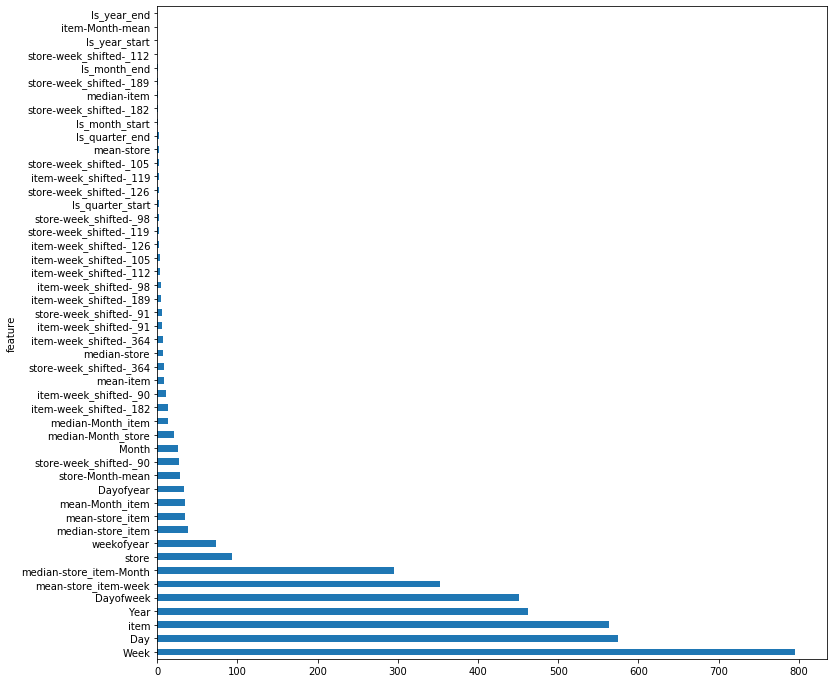

In [41]:
plot_fi(importance_df[:]);

In [42]:
merged_df.get_ftype_counts()

float64:dense    33
int64:dense      15
dtype: int64

In [43]:
# OHE FOR 0,1,9,10,12,13,14  Cols - Day, Dayofweek, Month, Week, item, store, weekofyear
print("Before OHE", merged_df.shape)
merged_df = pd.get_dummies(merged_df, columns=['Day', 'Dayofweek', 'Month', 'Week', 'item', 'store', 'weekofyear'])
print("After OHE", merged_df.shape)
test_x = merged_df[len_train:].values
all_x = merged_df[:len_train].values
all_y = target;

Before OHE (958000, 48)
After OHE (958000, 257)


In [44]:
def XGB_regressor(train_X, train_y, test_X, test_y= None, feature_names=None, seed_val=2018, num_rounds=500):

    param = {}
    param['objective'] = 'reg:linear'
    param['eta'] = 0.1
    param['max_depth'] = 5
    param['silent'] = 1
    param['eval_metric'] = 'mae'
    param['min_child_weight'] = 4
    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.8
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())

    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
        
    return model

In [45]:
model = XGB_regressor(train_X = all_x, train_y = all_y, test_X = test_x)
y_test = model.predict(xgb.DMatrix(test_x), ntree_limit = model.best_ntree_limit)

In [46]:
print('Inverting Box Cox Transformation')
y_test = inverse_boxcox(y_test, lambda_prophet) - 1

Inverting Box Cox Transformation


In [47]:
df = date_sales.reset_index()
df.columns = ['ds', 'y']

In [48]:
df.head()

,ds,y
0,2013-01-01,13.0
1,2013-01-02,11.0
2,2013-01-03,14.0
3,2013-01-04,13.0
4,2013-01-05,10.0


In [49]:
df['store'] = df_raw['store'].copy()
df['Week'] = df_raw['Week'].copy()
df['item'] = df_raw['item'].copy()

In [50]:
df = df.query('item == 1 & store == 1')

In [51]:
df.groupby(['Week','store','item'])['y'].mean().reset_index().head(10)

,Week,store,item,y
0,1,1,1,13.970588
1,2,1,1,13.200000
2,3,1,1,14.114286
3,4,1,1,13.828571
4,5,1,1,14.342857
5,6,1,1,14.114286
6,7,1,1,15.228571
7,8,1,1,14.371429
8,9,1,1,15.342857
9,10,1,1,15.771429


In [52]:
prediction_size = 31 
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y,store,Week,item
1792,2017-11-28,14.0,1,48,1
1793,2017-11-29,28.0,1,48,1
1794,2017-11-30,15.0,1,48,1


### Forecasting through Prophet

In [53]:
%%time
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(train_df[['ds','y']]);

CPU times: user 363 ms, sys: 31.6 ms, total: 395 ms
Wall time: 450 ms


In [54]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


In [55]:
%%time
forecast = m.predict(future)
forecast.tail(n=3)

CPU times: user 10.9 s, sys: 1 s, total: 11.9 s
Wall time: 4.65 s


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1823,2017-12-29,20.474896,12.299098,23.968419,20.474020,20.475511,-2.056775,-2.056775,-2.056775,2.272898,...,1.120657,1.120657,1.120657,-5.450330,-5.450330,-5.450330,0.0,0.0,0.0,18.418121
1824,2017-12-30,20.476881,14.732697,26.127204,20.475870,20.477539,-0.108707,-0.108707,-0.108707,2.272898,...,2.993410,2.993410,2.993410,-5.375015,-5.375015,-5.375015,0.0,0.0,0.0,20.368173
1825,2017-12-31,20.478865,15.485369,26.974848,20.477757,20.479618,0.737724,0.737724,0.737724,2.272898,...,3.780476,3.780476,3.780476,-5.315651,-5.315651,-5.315651,0.0,0.0,0.0,21.216589


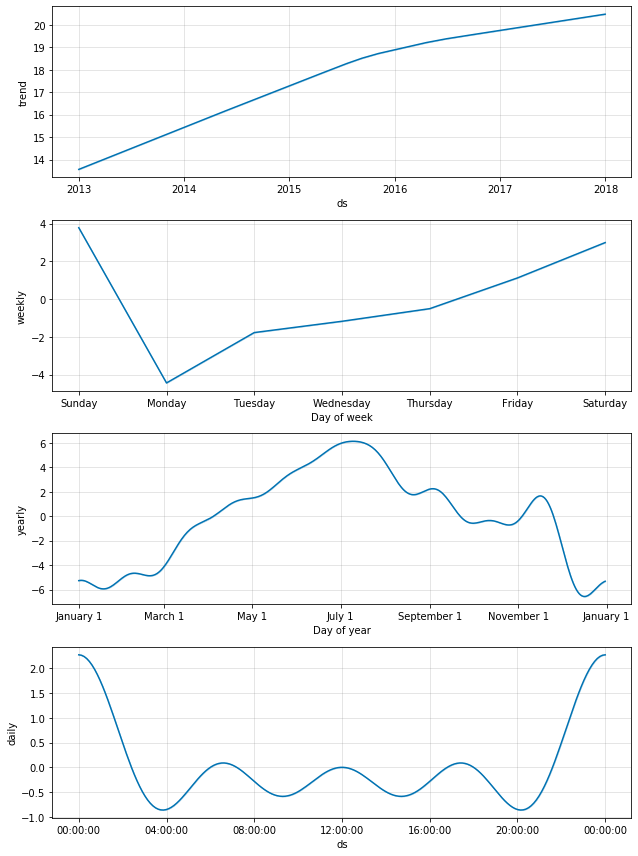

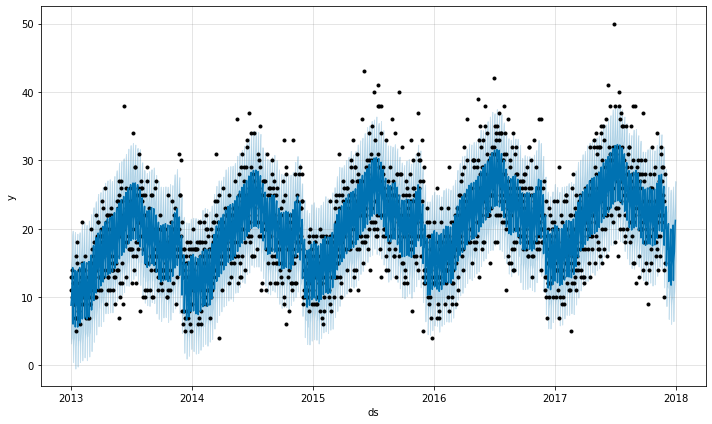

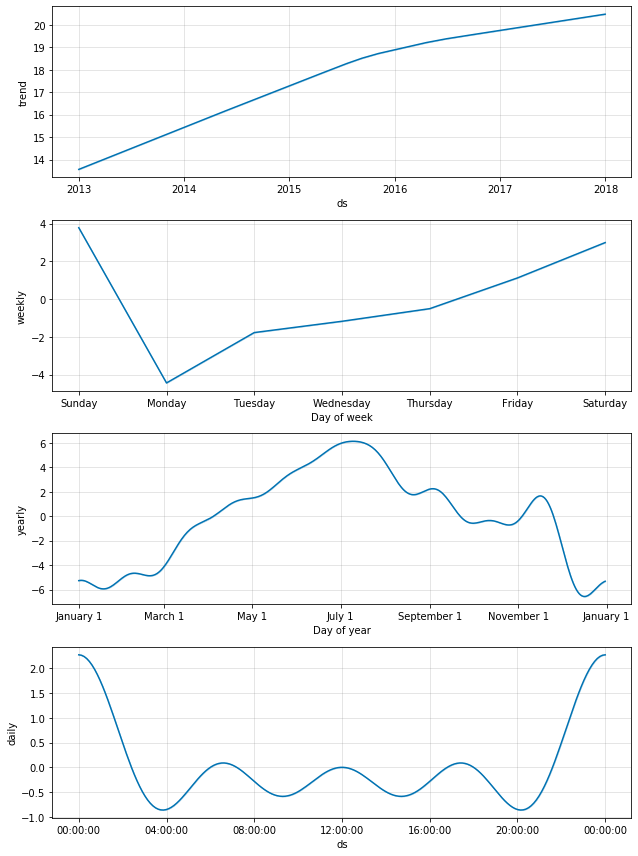

In [56]:
m.plot(forecast)
m.plot_components(forecast)

In [57]:
playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'lower_window' : 0,
  'upper_window' : 2}
)
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25','2018-01-01','2018-01-15','2018-02-14','2018-02-19'
                       ]),
  'lower_window': 0,
  'upper_window': 3,
})

holidays = pd.concat((playoffs, superbowls))

In [58]:
%%time
m_holi = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
m_holi.fit(train_df[['ds','y']]);

CPU times: user 394 ms, sys: 4.89 ms, total: 399 ms
Wall time: 399 ms


In [59]:
future_holi = m_holi.make_future_dataframe(periods=prediction_size)
future_holi.tail(n=3)

,ds
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


In [60]:
%%time
forecast_holi = m_holi.predict(future_holi)
forecast_holi.tail(n=3)

CPU times: user 12.6 s, sys: 1.05 s, total: 13.6 s
Wall time: 5.67 s


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1823,2017-12-29,20.490263,12.888779,23.936149,20.489488,20.491112,-1.991866,-1.991866,-1.991866,2.274483,...,1.115697,1.115697,1.115697,-5.382046,-5.382046,-5.382046,0.0,0.0,0.0,18.498397
1824,2017-12-30,20.492258,15.253185,26.288097,20.491349,20.493172,-0.033080,-0.033080,-0.033080,2.274483,...,2.998522,2.998522,2.998522,-5.306084,-5.306084,-5.306084,0.0,0.0,0.0,20.459178
1825,2017-12-31,20.494253,15.941031,27.319526,20.493240,20.495282,0.807840,0.807840,0.807840,2.274483,...,3.780327,3.780327,3.780327,-5.246970,-5.246970,-5.246970,0.0,0.0,0.0,21.302093


In [61]:
#from the docs..
forecast_holi[(forecast_holi['playoff'] + forecast_holi['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
1777,2017-11-13,0.000000,0.649477
1787,2017-11-23,0.000000,-0.487658
1788,2017-11-24,0.000000,-0.001047
1789,2017-11-25,0.000000,-0.669430
1790,2017-11-26,0.000000,0.649477
1818,2017-12-24,-0.277573,0.000000
1819,2017-12-25,-1.316638,-0.487658
1820,2017-12-26,1.165633,-0.001047
1821,2017-12-27,0.000000,-0.669430
1822,2017-12-28,0.000000,0.649477


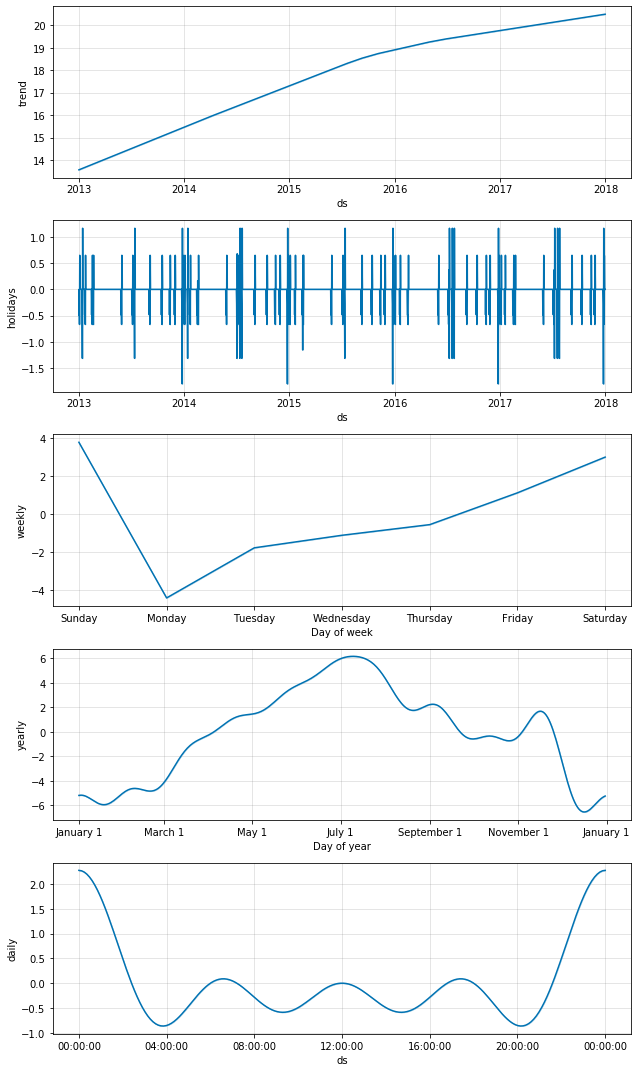

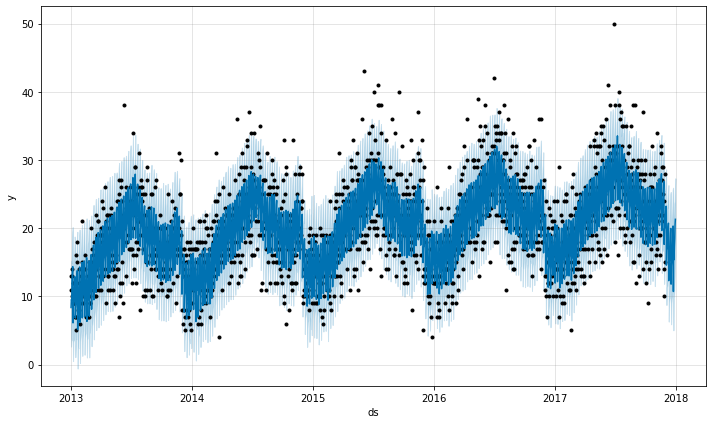

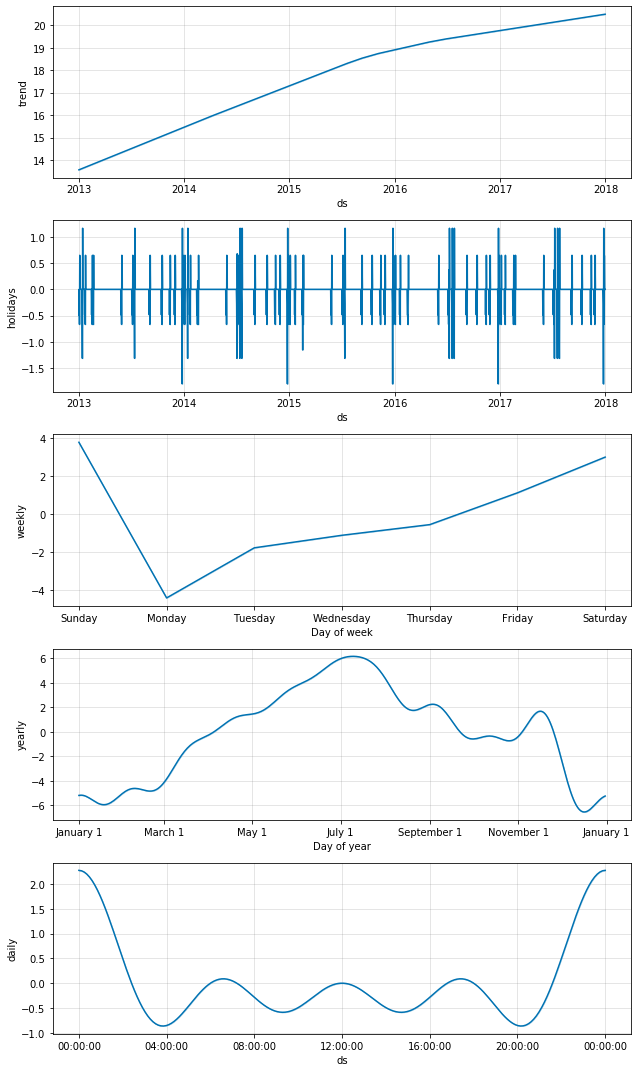

In [62]:
m_holi.plot(forecast_holi)
m_holi.plot_components(forecast_holi)

In [63]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, daily, daily_lower, daily_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [64]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [65]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(3)

,yhat,yhat_lower,yhat_upper,y,store,Week,item
ds,,,,,,,
2017-12-29,18.418121,12.299098,23.968419,15.0,1,52,1
2017-12-30,20.368173,14.732697,26.127204,27.0,1,52,1
2017-12-31,21.216589,15.485369,26.974848,23.0,1,52,1


In [66]:
cmp_df_holi = make_comparison_dataframe(df, forecast_holi)
cmp_df_holi.tail(3)

,yhat,yhat_lower,yhat_upper,y,store,Week,item
ds,,,,,,,
2017-12-29,18.498397,12.888779,23.936149,15.0,1,52,1
2017-12-30,20.459178,15.253185,26.288097,27.0,1,52,1
2017-12-31,21.302093,15.941031,27.319526,23.0,1,52,1


In [67]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [68]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print('Non Holiday', err_name, err_value)

Non Holiday MAPE 27.47626345415984
Non Holiday MAE 3.546516298332989


In [69]:
for err_name, err_value in calculate_forecast_errors(cmp_df_holi, prediction_size).items():
    print('Including Holiday', err_name, err_value)

Including Holiday MAPE 27.5881721098079
Including Holiday MAE 3.5428230164743857


In [70]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aqua"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aqua"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='sales'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'Sales on Store $1$ for Item $1$')

In [71]:
show_forecast(cmp_df_holi, prediction_size, 100, 'Sales on Store $1$ for Item $1$ Holidays Version')

### Prophet with Box-Cox Transformation

In [72]:
#train_df2 = df.copy().set_index('ds')
train_df2 = df[:-prediction_size]

In [73]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

In [74]:
%%time
m2 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m2.fit(train_df2[['ds','y']]);

CPU times: user 346 ms, sys: 4.96 ms, total: 351 ms
Wall time: 352 ms


In [75]:
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

In [76]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

In [77]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
cmp_df2.tail()

,yhat,yhat_lower,yhat_upper,y,store,Week,item
ds,,,,,,,
2017-12-27,15.443421,10.787759,21.251009,14.0,1,52,1
2017-12-28,16.153460,11.430783,21.923556,19.0,1,52,1
2017-12-29,17.758364,12.958216,23.571898,15.0,1,52,1
2017-12-30,19.519057,14.592608,25.870141,27.0,1,52,1
2017-12-31,20.379689,15.076469,26.718463,23.0,1,52,1


In [78]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print('Including Holidays', err_name, err_value)
# We Get Slight Improvement Over No Transformations !!!

Including Holidays MAPE 26.256199672466543
Including Holidays MAE 3.490802306630412


In [79]:
show_forecast(cmp_df, prediction_size, 100, 'No transformations')
show_forecast(cmp_df2, prediction_size, 100, 'With Box–Cox transformation')

#### Basic ARIMA

In [80]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


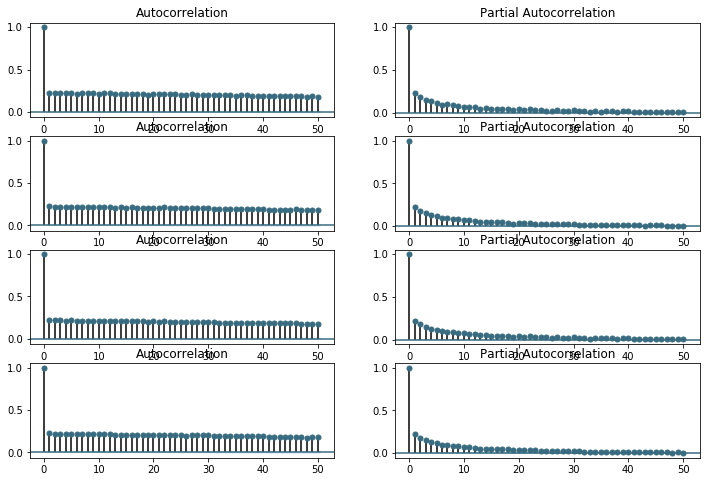

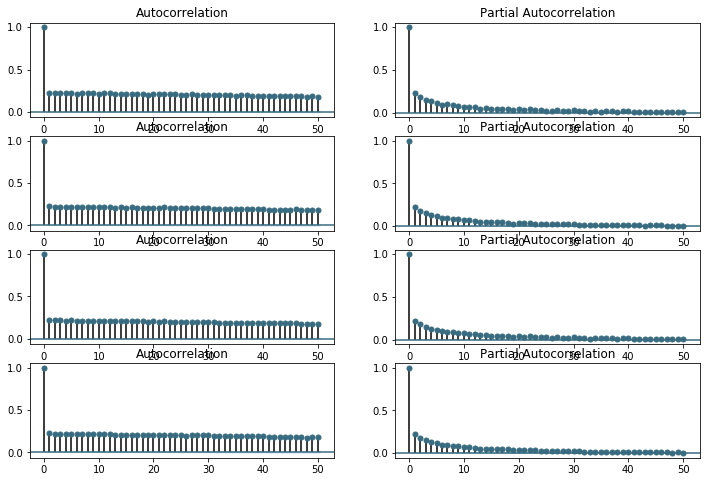

In [81]:
# figure for subplots
plt.figure(figsize = (12, 8))
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)
#these plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

In [82]:
cnt = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            cnt += 1
            if cnt % 50 :
                print('Current Iter - {}, ARIMA{}x{} 12 - AIC:{}'.format(cnt, param, param_seasonal, results.aic))
        except:
            continue

Current Iter - 1, ARIMA(0, 0, 0)x(0, 0, 0, 12) 12 - AIC:639.3903169231556
Current Iter - 2, ARIMA(0, 0, 0)x(0, 0, 1, 12) 12 - AIC:515.5599062881603
Current Iter - 3, ARIMA(0, 0, 0)x(0, 1, 0, 12) 12 - AIC:272.69049432052384
Current Iter - 4, ARIMA(0, 0, 0)x(0, 1, 1, 12) 12 - AIC:1708.814773805792
Current Iter - 5, ARIMA(0, 0, 0)x(0, 2, 0, 12) 12 - AIC:182.9331890195787
Current Iter - 6, ARIMA(0, 0, 0)x(1, 0, 0, 12) 12 - AIC:214.87722464483306
Current Iter - 7, ARIMA(0, 0, 0)x(1, 0, 1, 12) 12 - AIC:194.20262109965907
Current Iter - 8, ARIMA(0, 0, 0)x(1, 1, 0, 12) 12 - AIC:159.12960769430097
Current Iter - 9, ARIMA(0, 0, 0)x(1, 1, 1, 12) 12 - AIC:141.7038807344639
Current Iter - 10, ARIMA(0, 0, 0)x(1, 2, 0, 12) 12 - AIC:69.40423186088631
Current Iter - 11, ARIMA(0, 0, 0)x(2, 0, 0, 12) 12 - AIC:100.56580160005481
Current Iter - 12, ARIMA(0, 0, 0)x(2, 0, 1, 12) 12 - AIC:96.77916429412797
Current Iter - 13, ARIMA(0, 0, 0)x(2, 1, 0, 12) 12 - AIC:49.39821838607198
Current Iter - 14, ARIMA(0, 0

Current Iter - 112, ARIMA(0, 2, 1)x(1, 0, 1, 12) 12 - AIC:139.33456673943863
Current Iter - 113, ARIMA(0, 2, 1)x(1, 1, 0, 12) 12 - AIC:104.88137079556715
Current Iter - 114, ARIMA(0, 2, 1)x(1, 1, 1, 12) 12 - AIC:1407.2892492002895
Current Iter - 115, ARIMA(0, 2, 1)x(1, 2, 0, 12) 12 - AIC:78.22156636027866
Current Iter - 116, ARIMA(0, 2, 1)x(2, 0, 0, 12) 12 - AIC:101.66087310458308
Current Iter - 117, ARIMA(0, 2, 1)x(2, 0, 1, 12) 12 - AIC:102.84085593318702
Current Iter - 118, ARIMA(0, 2, 1)x(2, 1, 0, 12) 12 - AIC:75.16175393994385
Current Iter - 119, ARIMA(0, 2, 1)x(2, 1, 1, 12) 12 - AIC:77.1512875456214
Current Iter - 120, ARIMA(0, 2, 1)x(2, 2, 0, 12) 12 - AIC:39.952149446362014
Current Iter - 121, ARIMA(0, 2, 2)x(0, 0, 0, 12) 12 - AIC:379.2976443370544
Current Iter - 122, ARIMA(0, 2, 2)x(0, 0, 1, 12) 12 - AIC:269.39710776834033
Current Iter - 123, ARIMA(0, 2, 2)x(0, 1, 0, 12) 12 - AIC:140.78824486394578
Current Iter - 124, ARIMA(0, 2, 2)x(0, 1, 1, 12) 12 - AIC:1297.9469024330083
Curr

Current Iter - 222, ARIMA(1, 1, 2)x(2, 0, 1, 12) 12 - AIC:68.18419105446674
Current Iter - 223, ARIMA(1, 1, 2)x(2, 1, 0, 12) 12 - AIC:47.89910412804872
Current Iter - 224, ARIMA(1, 1, 2)x(2, 1, 1, 12) 12 - AIC:924.9486425204024
Current Iter - 225, ARIMA(1, 1, 2)x(2, 2, 0, 12) 12 - AIC:27.256829511357523
Current Iter - 226, ARIMA(1, 2, 0)x(0, 0, 0, 12) 12 - AIC:398.7159569562058
Current Iter - 227, ARIMA(1, 2, 0)x(0, 0, 1, 12) 12 - AIC:284.53287238901885
Current Iter - 228, ARIMA(1, 2, 0)x(0, 1, 0, 12) 12 - AIC:162.3899765625639
Current Iter - 229, ARIMA(1, 2, 0)x(0, 1, 1, 12) 12 - AIC:1342.4474142723127
Current Iter - 230, ARIMA(1, 2, 0)x(0, 2, 0, 12) 12 - AIC:145.25306745167555
Current Iter - 231, ARIMA(1, 2, 0)x(1, 0, 0, 12) 12 - AIC:158.9551046195505
Current Iter - 232, ARIMA(1, 2, 0)x(1, 0, 1, 12) 12 - AIC:161.36430071521684
Current Iter - 233, ARIMA(1, 2, 0)x(1, 1, 0, 12) 12 - AIC:115.18678383288972
Current Iter - 234, ARIMA(1, 2, 0)x(1, 1, 1, 12) 12 - AIC:1363.1163149516224
Curre

Current Iter - 332, ARIMA(2, 1, 1)x(0, 0, 1, 12) 12 - AIC:271.94962335337914
Current Iter - 333, ARIMA(2, 1, 1)x(0, 1, 0, 12) 12 - AIC:142.19540024786252
Current Iter - 334, ARIMA(2, 1, 1)x(0, 1, 1, 12) 12 - AIC:nan
Current Iter - 335, ARIMA(2, 1, 1)x(0, 2, 0, 12) 12 - AIC:127.37328668568469
Current Iter - 336, ARIMA(2, 1, 1)x(1, 0, 0, 12) 12 - AIC:137.36448742988887
Current Iter - 337, ARIMA(2, 1, 1)x(1, 0, 1, 12) 12 - AIC:140.40782870057475
Current Iter - 338, ARIMA(2, 1, 1)x(1, 1, 0, 12) 12 - AIC:93.99117586911817
Current Iter - 339, ARIMA(2, 1, 1)x(1, 1, 1, 12) 12 - AIC:2341.799758849113
Current Iter - 340, ARIMA(2, 1, 1)x(1, 2, 0, 12) 12 - AIC:47.61057846783795
Current Iter - 341, ARIMA(2, 1, 1)x(2, 0, 0, 12) 12 - AIC:69.87389090844394
Current Iter - 342, ARIMA(2, 1, 1)x(2, 0, 1, 12) 12 - AIC:70.52332779284434
Current Iter - 343, ARIMA(2, 1, 1)x(2, 1, 0, 12) 12 - AIC:44.29928242559487
Current Iter - 344, ARIMA(2, 1, 1)x(2, 1, 1, 12) 12 - AIC:nan
Current Iter - 345, ARIMA(2, 1, 1)x

In [83]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 0, 1),
                                seasonal_order=(2, 2, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8549      0.489     -1.747      0.081      -1.814       0.104
ar.L2         -0.5007      0.383     -1.309      0.191      -1.251       0.249
ma.L1         -1.0001   1824.519     -0.001      1.000   -3576.992    3574.991
ar.S.L12      -1.0663      0.018    -58.640      0.000      -1.102      -1.031
ar.S.L24      -0.0254      0.007     -3.500      0.000      -0.040      -0.011
sigma2         0.0685    124.903      0.001      1.000    -244.737     244.874


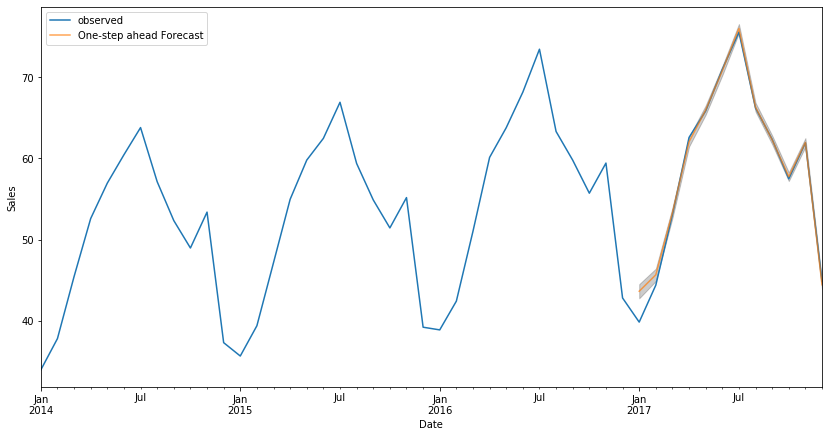

In [84]:
## Validating Forecast
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

In [85]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#The MSE is a measure of the quality of an estimator — it is always non-negative, 
#and the smaller the MSE, the closer we are to finding the line of best fit.

The Mean Squared Error of our forecasts is 1.41


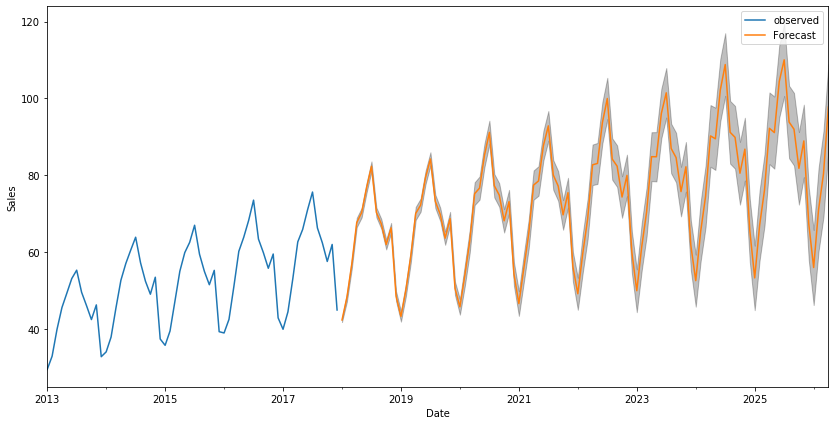

In [86]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

In [88]:
subs = pd.read_csv(f'sample_submission.csv')

In [89]:
subs.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


In [90]:
out_df_lgb = pd.DataFrame({'id': subs.id.astype(np.int32), 'sales': sub_preds.astype(np.int32)})
out_df_xgb = pd.DataFrame({'id': subs.id.astype(np.int32), 'sales': y_test.astype(np.int32)})
out_df_combined = pd.DataFrame({'id': subs.id.astype(np.int32), 'sales': ((sub_preds + y_test + 4)/2.).astype(np.int32)})
out_df_combined_25_75 = pd.DataFrame({'id': subs.id.astype(np.int32), 'sales': ((sub_preds *.25 + y_test *.75 + 4)).astype(np.int32)})

out_df_lgb.to_csv('submission_lgbm.csv', index=False)
out_df_xgb.to_csv('submission_xgb.csv', index=False)
out_df_combined.to_csv('submission_combined.csv', index=False)
out_df_combined_25_75.to_csv('submission_combined_25_75.csv', index=False)

### Keras Embedding

In [93]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, merge, Embedding, Input, Concatenate
from keras.models import Model as KerasModel
import keras.backend as K

Using TensorFlow backend.


In [94]:
cat_cols = ['Day', 'Dayofweek', 'Month', 'Week', 'item', 'store', 'weekofyear','Year']
for cols in cat_cols:
    df_raw[cols] = df_raw[cols].astype('category')
    df_test[cols] = df_test[cols].astype('category')

In [95]:
df_raw_cats = df_raw[cat_cols].copy()
df_test_cats = df_test[cat_cols].copy()

In [96]:
cat_cols

['Day', 'Dayofweek', 'Month', 'Week', 'item', 'store', 'weekofyear', 'Year']

In [97]:
df_raw_cats.head()

,Day,Dayofweek,Month,Week,item,store,weekofyear,Year
0,1,1,1,1,1,1,1,2013
1,2,2,1,1,1,1,1,2013
2,3,3,1,1,1,1,1,2013
3,4,4,1,1,1,1,1,2013
4,5,5,1,1,1,1,1,2013


In [98]:
def split_features(X):
    
    X_list = []
    
    day = X[..., [0]]
    X_list.append(day)

    day_of_week = X[..., [1]]
    X_list.append(day_of_week)

    month = X[..., [2]]
    X_list.append(month)

    week_of_year = X[..., [6]]
    X_list.append(week_of_year)
    
    item = X[..., [4]]
    X_list.append(item)
    
    store = X[..., [5]]
    X_list.append(store)
    
    year = X[..., [7]]
    X_list.append(year)

    return X_list

In [107]:
def custom_smape(x, x_): # From the Public Kernel https://www.kaggle.com/rezas26/simple-keras-starter        
    return K.mean(2*K.abs(x-x_)/(K.abs(x)+K.abs(x_)))
    
class NN_with_EntityEmbedding():

    def __init__(self, X_train, y_train):
        
        super().__init__()
        
        self.epochs = 3
        self.__build_keras_model()
        self.fit(X_train, y_train)
    
    def preprocessing(self, X):
        
        X_list = split_features(X)
        return X_list

    def __build_keras_model(self):
        
        model_day = Input(shape=(1,))
        output_day = Embedding(32, 16, name='day_embedding')(model_day)
        output_day = Reshape(target_shape=(16,))(output_day)

        model_dow = Input(shape=(1,))
        output_dow = Embedding(7, 5, name='dow_embedding')(model_dow)
        output_dow = Reshape(target_shape=(5,))(output_dow)
        
        input_month = Input(shape=(1,))
        output_month = Embedding(13, 6, name='month_embedding')(input_month)
        output_month = Reshape(target_shape=(6,))(output_month)
        
        model_woy = Input(shape=(1,))
        output_woy = Embedding(53, 26, name='week_embedding')(model_woy)
        output_woy = Reshape(target_shape=(26,))(output_woy)
        
        model_item = Input(shape=(1,))
        output_item = Embedding(51, 26, name='item_embedding')(model_item)
        output_item = Reshape(target_shape=(26,))(output_item)
        
        model_store = Input(shape=(1,))
        output_store = Embedding(11, 6, name='store_embedding')(model_store)
        output_store = Reshape(target_shape=(6,))(output_store)
        
        model_year = Input(shape=(1,))
        output_year = Embedding(7, 3, name='year_embedding')(model_year)
        output_year = Reshape(target_shape=(3,))(output_year)

        input_model = [model_day, model_dow, input_month,
                       model_woy, model_item, model_store, model_year]

        output_embeddings = [output_day, output_dow, output_month,
                             output_woy, output_item, output_store, output_year]

        output_model = Concatenate()(output_embeddings)
        output_model = Dense(128, kernel_initializer="glorot_uniform")(output_model)
        output_model = Activation('relu')(output_model)
        output_model = Dense(32, kernel_initializer="glorot_uniform")(output_model)
        output_model = Activation('relu')(output_model)
        output_model = Dense(1)(output_model)

        self.model = KerasModel(inputs=input_model, outputs=output_model)
        self.model.compile(loss= custom_smape, optimizer='sgd')


    def fit(self, X_train, y_train):
        self.model.fit(self.preprocessing(X_train), y_train, epochs=self.epochs, batch_size=64)

    def guess(self, features):
        features = self.preprocessing(features)
        result = self.model.predict(features).flatten()
        return result

In [108]:
nn = NN_with_EntityEmbedding(df_raw_cats.values, original_target)

Epoch 1/3


InvalidArgumentError:  indices[0,0] = 2013 is not in [0, 7)
	 [[node year_embedding_4/embedding_lookup (defined at /Users/hussainmohammadyousuf/Downloads/venv/tsenv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_6537]

Function call stack:
keras_scratch_graph
